In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/mayo-clinic-strip-ai/sample_submission.csv
/kaggle/input/mayo-clinic-strip-ai/train.csv
/kaggle/input/mayo-clinic-strip-ai/test.csv
/kaggle/input/mayo-clinic-strip-ai/other.csv
/kaggle/input/mayo-clinic-strip-ai/other/314263_0.tif
/kaggle/input/mayo-clinic-strip-ai/other/0b33d7_0.tif
/kaggle/input/mayo-clinic-strip-ai/other/54334d_0.tif
/kaggle/input/mayo-clinic-strip-ai/other/84c279_0.tif
/kaggle/input/mayo-clinic-strip-ai/other/cca9eb_0.tif
/kaggle/input/mayo-clinic-strip-ai/other/880188_1.tif
/kaggle/input/mayo-clinic-strip-ai/other/2e3078_0.tif
/kaggle/input/mayo-clinic-strip-ai/other/9daa03_0.tif
/kaggle/input/mayo-clinic-strip-ai/other/065053_0.tif
/kaggle/input/mayo-clinic-strip-ai/other/8acdfa_0.tif
/kaggle/input/mayo-clinic-strip-ai/other/91530f_0.tif
/kaggle/input/mayo-clinic-strip-ai/other/a2253f_0.tif
/kaggle/input/mayo-clinic-strip-ai/other/f5eb8f_1.tif
/kaggle/input/mayo-clinic-strip-ai/other/ab830f_0.tif
/kaggle/input/mayo-clinic-strip-ai/other/d17ad3_2.tif

In [2]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import cv2

#Preprocessing
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder,StandardScaler
from sklearn import preprocessing
#Model
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import lightgbm as lgb

In [3]:
train = pd.read_csv('../input/mayo-clinic-strip-ai/train.csv')
test = pd.read_csv('../input/mayo-clinic-strip-ai/test.csv')
sample = pd.read_csv('../input/mayo-clinic-strip-ai/sample_submission.csv')
train_image_path = '../input/mayo-clinic-strip-ai/train/'
test_image_path = '../input/mayo-clinic-strip-ai/test/'

In [4]:
print(f'Train_Shape: {train.shape},Test_Shape: {test.shape},Sample_Shape: {sample.shape}')
display(train.sample(2))
display(test.sample(2))
display(sample.sample(2))

Train_Shape: (754, 5),Test_Shape: (4, 4),Sample_Shape: (4, 3)


,image_id,center_id,patient_id,image_num,label
101,2244d2_0,11,2244d2,0,CE
103,2394f6_0,11,2394f6,0,CE


,image_id,center_id,patient_id,image_num
1,008e5c_0,11,008e5c,0
0,006388_0,11,006388,0


,patient_id,CE,LAA
2,00c058,0.5,0.5
1,008e5c,0.5,0.5


/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='label', ylabel='count'>

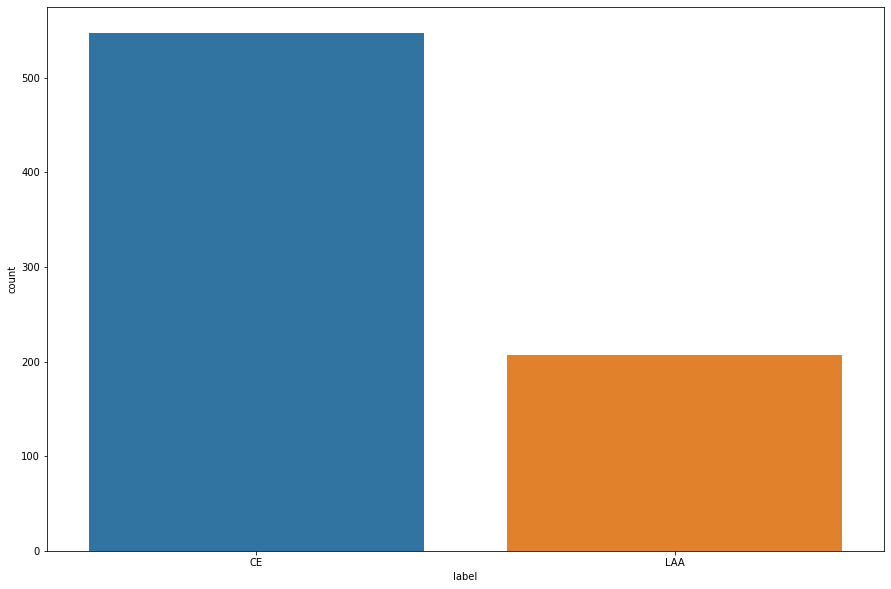

In [5]:
plt.figure(figsize=(15,10))
sns.countplot(train['label'])

KFOLD

In [6]:
#add extra one columns
train['kfold']=-1
#Distributing the data 5 shares
kfold = model_selection.KFold(n_splits=5, shuffle= True, random_state = 12)
for fold, (train_indicies, valid_indicies) in enumerate(kfold.split(X=train)):
    #print(fold,train_indicies,valid_indicies)
    train.loc[valid_indicies,'kfold'] = fold

    
print(train.kfold.value_counts()) #total data 300000 = kfold split :5 * 60000

#output of train folds data
train.to_csv("trainfold_5.csv",index=False)

1    151
0    151
2    151
3    151
4    150
Name: kfold, dtype: int64


BINARY MAPPING

In [7]:
label_map = {'CE' : 0, 'LAA':1}
train['label'] = train['label'].map(label_map)
train.sample(2)

,image_id,center_id,patient_id,image_num,label,kfold
710,f56138_0,4,f56138,0,0,0
607,d4791c_0,10,d4791c,0,0,3


Cat Boost Algorithm

In [8]:
from catboost import CatBoostRegressor,CatBoostClassifier

#features(categorical and numerical datas separate)
useful_features = [c for c in train.columns if c not in ("image_id","patient_id","kfold","label")]
object_cols = [col for col in useful_features]
#numerical_cols = [col for col in useful_features]
test = test[useful_features]


for fold in range(5):
    xtrain = train[train.kfold != fold].reset_index(drop=True)
    xvalid = train[train.kfold == fold].reset_index(drop=True)
    xtest = test.copy()
    
    ytrain = xtrain.label
    yvalid = xvalid.label
    
    xtrain = xtrain[useful_features]
    xvalid = xvalid[useful_features]
        
    #Model hyperparameter of XGboostRegressor
    #catboost model
    catpara={
        'subsample': 0.95312,
        'learning_rate': 0.00135356,
        "max_depth": 3,
        "min_data_in_leaf":77,
        'random_state':12,
        'n_estimators':50000,
        'rsm':0.5,
        'l2_leaf_reg': 0.02247766515106271
    }
    
    model=CatBoostRegressor(**catpara)
    model.fit(xtrain,ytrain,early_stopping_rounds=300,eval_set=[(xvalid,yvalid)],verbose=1000)
    model.fit(xtrain,ytrain,early_stopping_rounds=300,eval_set=[(xvalid,yvalid)],verbose=False)
    preds_valid = model.predict(xvalid)
    

    #way of output is display
    print(f"fold:{fold}")

0:	learn: 0.4415131	test: 0.4652777	best: 0.4652777 (0)	total: 53ms	remaining: 44m 8s
1000:	learn: 0.4390503	test: 0.4613119	best: 0.4613119 (999)	total: 164ms	remaining: 8.05s
2000:	learn: 0.4374128	test: 0.4587265	best: 0.4587265 (2000)	total: 281ms	remaining: 6.74s
3000:	learn: 0.4361246	test: 0.4567032	best: 0.4567032 (2999)	total: 393ms	remaining: 6.16s
4000:	learn: 0.4350848	test: 0.4549328	best: 0.4549324 (3999)	total: 510ms	remaining: 5.86s
5000:	learn: 0.4339222	test: 0.4526907	best: 0.4526901 (4996)	total: 624ms	remaining: 5.61s
6000:	learn: 0.4327402	test: 0.4501790	best: 0.4501790 (6000)	total: 736ms	remaining: 5.4s
7000:	learn: 0.4317012	test: 0.4482451	best: 0.4482451 (7000)	total: 840ms	remaining: 5.16s
8000:	learn: 0.4308745	test: 0.4471620	best: 0.4471615 (7998)	total: 965ms	remaining: 5.06s
9000:	learn: 0.4302952	test: 0.4465876	best: 0.4465845 (8990)	total: 1.07s	remaining: 4.88s
10000:	learn: 0.4298368	test: 0.4461224	best: 0.4461186 (9996)	total: 1.18s	remaining: 4

In [9]:
test_predict = model.predict(xtest)
test_predict

array([0.26989444, 0.26989444, 0.26989444, 0.26989444])

In [10]:
#test_pred_str = LB.inverse_transform(test_pre)
sample.loc[:,"CE"] = test_predict[0]
sample.loc[:,"LAA"] = test_predict[1]
sample.to_csv('submission.csv',index=False)

In [11]:
sample.head()

,patient_id,CE,LAA
0,006388,0.269894,0.269894
1,008e5c,0.269894,0.269894
2,00c058,0.269894,0.269894
3,01adc5,0.269894,0.269894


Image Data

In [12]:
from PIL import Image
import os,glob
import tifffile as tif
from tqdm import tqdm

In [13]:
# #Lets Print a sample
# img=tif.imread(os.path.join(train_image_path,str(train.loc[0,'image_id'])+'.tif'))
# img.shape

In [14]:
DATASET_FOLDER = "/kaggle/input/mayo-clinic-strip-ai/"
df_train= pd.read_csv('../input/mayo-clinic-strip-ai/train.csv')

In [15]:
from PIL import Image
from tqdm.auto import tqdm

Image.MAX_IMAGE_PIXELS = 5_000_000_000

sizes = []
for name in tqdm(df_train["image_id"]):
    img = Image.open(os.path.join(DATASET_FOLDER, "train", f"{name}.tif"))
    sizes.append({"img_height": img.height, "img_width": img.width})

df_sizes = pd.DataFrame(sizes)
for col in df_sizes.columns:
    df_train[col] = df_sizes[col]

  0%|          | 0/754 [00:00<?, ?it/s]

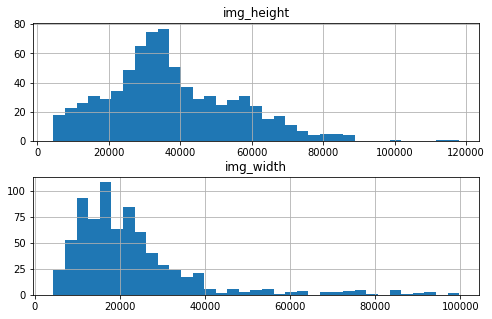

In [16]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(8, 5))
for i, col in enumerate(["img_height", "img_width"]):
    _= df_train[[col]].hist(ax=axes[i], bins=35)

In [17]:
import plotly.express as px

df_sizes = df_train[["img_width", "img_height", "label"]]
for col in ("img_width", "img_height"):
    df_sizes[col] = [round(i / 1000) * 1000 for i in df_sizes[col]]

df_sizes = df_sizes.groupby(["img_width", "img_height", "label"], as_index=False).size()
# display(df_sizes.head())
fig = px.scatter(df_sizes, x="img_width", y="img_height", size="size", color="label")
# fig.gca().axis('equal')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


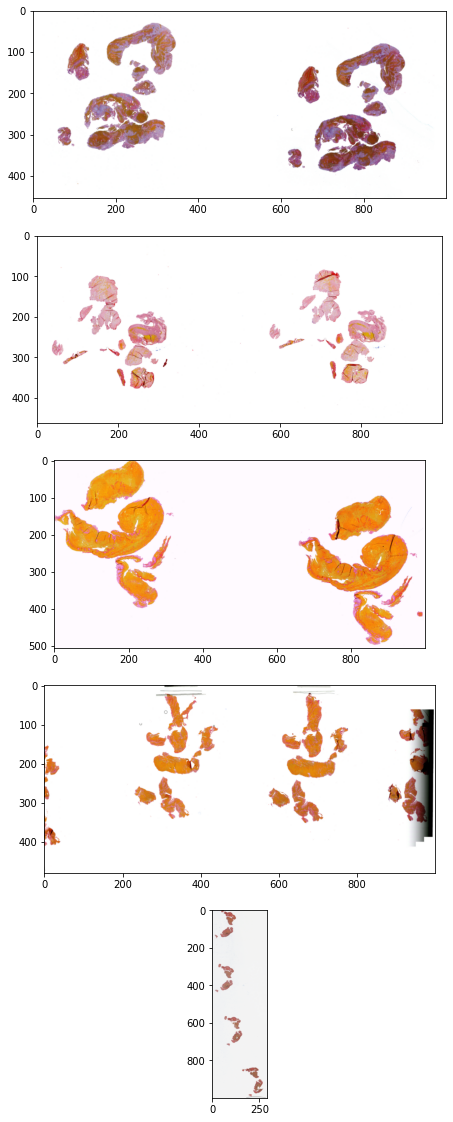

In [18]:
fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(9, 20))
for i, name in enumerate(df_train["image_id"].sample(5)):
    img = Image.open(os.path.join(DATASET_FOLDER, "train", f"{name}.tif"))
    img.thumbnail((1000, 1000), resample=Image.Resampling.BILINEAR, reducing_gap=20)
    axes[i].imshow(img.transpose(Image.Resampling.BILINEAR))